<a href="https://www.kaggle.com/code/aabdollahii/multilingual-mobile-app-review-sentiment?scriptVersionId=256355032" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multilingual-mobile-app-reviews-dataset-2025/multilingual_mobile_app_reviews_2025.csv


# loading data and understanding about it

In [2]:
import pandas as pd
DATA_PATH = "/kaggle/input/multilingual-mobile-app-reviews-dataset-2025/multilingual_mobile_app_reviews_2025.csv"
df = pd.read_csv(DATA_PATH)

In [3]:
df.shape

(2514, 15)

In [4]:
df.columns.tolist()

['review_id',
 'user_id',
 'app_name',
 'app_category',
 'review_text',
 'review_language',
 'rating',
 'review_date',
 'verified_purchase',
 'device_type',
 'num_helpful_votes',
 'user_age',
 'user_country',
 'user_gender',
 'app_version']

- We probably remove user_id, reveiw_id, depend on project goals we set in future. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_id          2514 non-null   int64  
 1   user_id            2514 non-null   int64  
 2   app_name           2514 non-null   object 
 3   app_category       2514 non-null   object 
 4   review_text        2455 non-null   object 
 5   review_language    2514 non-null   object 
 6   rating             2477 non-null   float64
 7   review_date        2514 non-null   object 
 8   verified_purchase  2514 non-null   bool   
 9   device_type        2514 non-null   object 
 10  num_helpful_votes  2514 non-null   int64  
 11  user_age           2514 non-null   float64
 12  user_country       2473 non-null   object 
 13  user_gender        1927 non-null   object 
 14  app_version        2484 non-null   object 
dtypes: bool(1), float64(2), int64(3), object(9)
memory usage: 277.6+ KB


- lots of objects in data set.We do not need to convert all of them to numeric.

In [6]:
df.head()

,review_id,user_id,app_name,app_category,review_text,review_language,rating,review_date,verified_purchase,device_type,num_helpful_votes,user_age,user_country,user_gender,app_version
0,1,1967825,MX Player,Travel & Local,Qui doloribus consequuntur. Perspiciatis tempo...,no,1.3,2024-10-09 19:26:40,True,Android Tablet,65,14.0,China,Female,1.4
1,2,9242600,Tinder,Navigation,"Great app but too many ads, consider premium v...",ru,1.6,2024-06-21 17:29:40,True,iPad,209,18.0,Germany,Male,8.9
2,3,7636477,Netflix,Dating,The interface could be better but overall good...,es,3.6,2024-10-31 13:47:12,True,iPad,163,67.0,Nigeria,Male,2.8.37.5926
3,4,209031,Venmo,Productivity,"Latest update broke some features, please fix ...",vi,3.8,2025-03-12 06:16:22,True,iOS,664,66.0,India,Female,10.2
4,5,7190293,Google Drive,Education,"Perfect for daily use, highly recommend to eve...",tl,3.2,2024-04-21 03:48:27,True,iPad,1197,40.0,South Korea,Prefer not to say,4.7


- I see some problems in the first 5 rows, like Netflix categories and ....... but anyway, we are gonna work on this just for fun and practice.

In [7]:
if 'review_language' in df.columns:
    print("==== Sample Reviews by Language ====")
    print(df.groupby('review_language').head(1)[['review_language', 'review_text']])

==== Sample Reviews by Language ====
   review_language                                        review_text
0               no  Qui doloribus consequuntur. Perspiciatis tempo...
1               ru  Great app but too many ads, consider premium v...
2               es  The interface could be better but overall good...
3               vi  Latest update broke some features, please fix ...
4               tl  Perfect for daily use, highly recommend to eve...
5               th  Works perfectly on my device, no complaints at...
6               da  Basso bello società paese. Quello mostrare verso.
7               ja  Odcinek skład zarówno zgodnie zaś. Powoli gdyb...
8               ms  Eius odio facilis fuga distinctio eaque. Non c...
9               fr       Husband at tree note responsibility defense.
10              it  Works perfectly on my device, no complaints at...
11              nl  The interface could be better but overall good...
13              hi  Some bugs need fixing but general

* 2514 rows, 15 columns — small enough to experiment easily without GPU.
The mix of review text, app metadata, user demographics, and technical details (device type, app version) gives us plenty of potential features.
* review_text → 59 missing (2.3%).
rating → 37 missing (1.47%) — important since this is our sentiment target.
user_country → 41 missing.
user_gender → 587 missing (23%) — gender might be unreliable for modeling.
app_version → 30 missing.
* review_language shows a wide multilingual spread (no, ru, es, vi, tl, th, da, ja, ms, fr, it, nl, hi, ar, zh, id, pl, ko, sv, pt, tr, fi, de, en… and probably more).
* This will test our multilingual NLP preprocessing — possibly requiring:
Translation to a single language (English) or
Multilingual transformer embeddings.
* Some reviews look auto-generated or synthetic (a few are unrelated phrases).
→ Could be synthetic dataset creation — fine for practice, but don’t expect real linguistic distribution.

# making data ready for sentiment analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Drop rows with missing review_text or rating
df = df.dropna(subset=['review_text', 'rating']).reset_index(drop=True)



In [9]:
#  Create sentiment label
def rating_to_sentiment(r):
    if r >= 4.0:
        return "Positive"
    elif r >= 3.0:
        return "Neutral"
    else:
        return "Negative"

df['sentiment'] = df['rating'].apply(rating_to_sentiment)

In [10]:
#  Check distribution
print("Sentiment Counts:")
print(df['sentiment'].value_counts())

Sentiment Counts:
sentiment
Negative    1171
Positive     630
Neutral      617
Name: count, dtype: int64


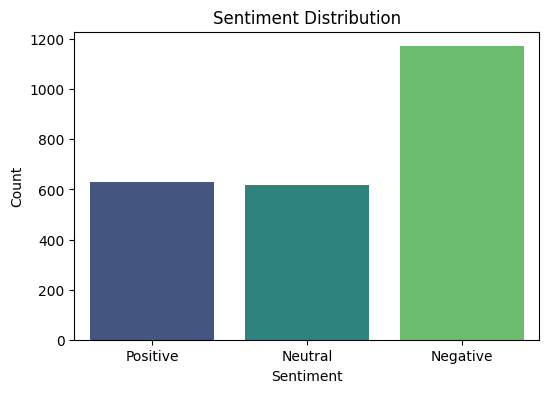

In [11]:
# Plot
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['Positive','Neutral','Negative'], palette='viridis')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

- as you can see, most of the data is negative. Maybe this is not suitable for ML models. it’s not extreme enough to kill model performance.

# explore the multilingual side

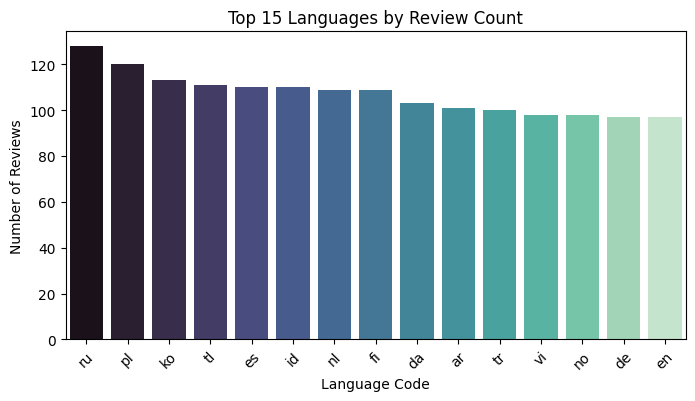

In [12]:
# Top languages by review count
lang_counts = df['review_language'].value_counts().head(15)
plt.figure(figsize=(8,4))
sns.barplot(x=lang_counts.index, y=lang_counts.values, palette='mako')
plt.title("Top 15 Languages by Review Count")
plt.xlabel("Language Code")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

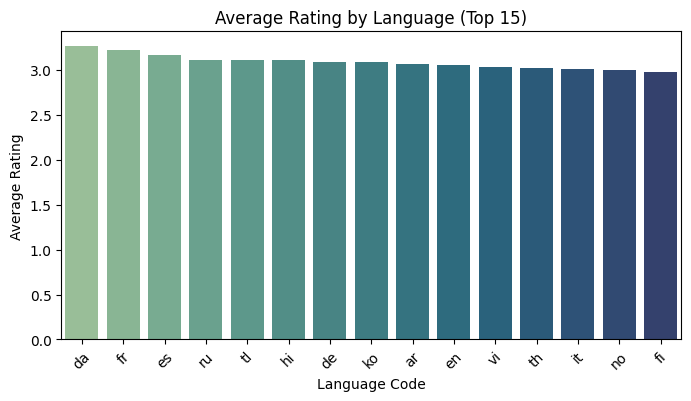

In [13]:
# 2 — Average rating by language (top 15 languages)
avg_rating = df.groupby('review_language')['rating'].mean().sort_values(ascending=False).head(15)
plt.figure(figsize=(8,4))
sns.barplot(x=avg_rating.index, y=avg_rating.values, palette='crest')
plt.title("Average Rating by Language (Top 15)")
plt.xlabel("Language Code")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()

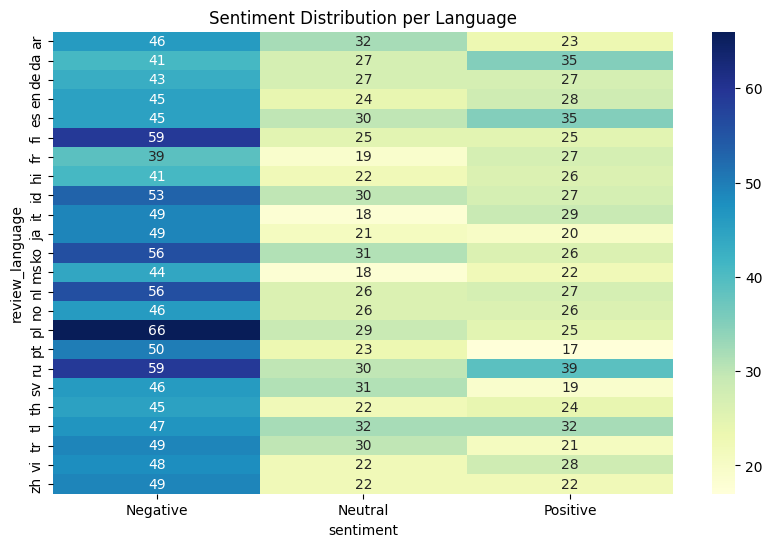

In [14]:
# Sentiment count by language heatmap
sent_lang = df.groupby(['review_language','sentiment'])['sentiment'].count().unstack().fillna(0)
plt.figure(figsize=(10,6))
sns.heatmap(sent_lang, annot=True, fmt='g', cmap='YlGnBu')
plt.title("Sentiment Distribution per Language")
plt.show()

* Language Popularity
Top 3 languages by review count: ru (Russian), pl (Polish), ko (Korean).
Even English (en) isn’t near the top — unusual compared to most app review corpora.
This strongly confirms we need a multilingual approach, not just English-only.
* Highest rated languages: Danish (da), French (fr), Spanish (es).
Lowest average ratings: Finnish (fi), Norwegian (no), Italian (it).
This could be cultural bias, data generation bias, or just noise from synthetic data.
* Sentiment Patterns
Most languages skew toward Negative sentiment (Negative column typically bigger).
Some languages have more balanced sentiment — e.g., fr, vi, tl.
A few are heavily negative, e.g., zh (Chinese) with 66 negative out of total.
* 

# data cleaning and Tokenization

In [15]:
import re
from transformers import AutoTokenizer
import transformers


In [16]:
# data 
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)      # remove HTML tags
    text = re.sub(r'http\S+', ' ', text)    # remove URLs
    text = re.sub(r'[^0-9a-zA-Z\u00C0-\u024F\u1E00-\u1EFF\u0600-\u06FF\u0400-\u04FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text)        # remove extra spaces
    return text.strip()

df['clean_text'] = df['review_text'].astype(str).apply(clean_text)
print("Sample cleaned texts:")
print(df[['review_text','clean_text']].head())

Sample cleaned texts:
                                         review_text  \
0  Qui doloribus consequuntur. Perspiciatis tempo...   
1  Great app but too many ads, consider premium v...   
2  The interface could be better but overall good...   
3  Latest update broke some features, please fix ...   
4  Perfect for daily use, highly recommend to eve...   

                                          clean_text  
0  qui doloribus consequuntur perspiciatis tempor...  
1  great app but too many ads consider premium ve...  
2  the interface could be better but overall good...  
3  latest update broke some features please fix soon  
4  perfect for daily use highly recommend to ever...  


In [17]:
# Tokenization using multilingual model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

encodings = tokenizer(
    df['clean_text'].tolist(),
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

* Unicode ranges in regex keep accented Latin, Arabic, Cyrillic — so multilingual info stays intact.
* xlm-roberta-base tokenizer supports over 100 languages, so we don’t lose meaning through translation.
* max_length=128 is enough for review-length text while keeping training fast.
* "xlm-roberta-base" is a multilingual transformer model from Hugging Face.
* It supports 100+ languages, trained on CommonCrawl, so it’s ideal for our mixed‑language reviews.
* We’re actually not loading the model yet — just storing the name for the tokenizer step.

In [18]:
# Example: print tensor shapes
print("Token IDs shape:", encodings['input_ids'].shape)
print("Attention mask shape:", encodings['attention_mask'].shape)

Token IDs shape: torch.Size([2418, 44])
Attention mask shape: torch.Size([2418, 44])


# label encoding and modeling

In [19]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import warnings
warnings.filterwarnings('ignore')

2025-08-16 19:43:16.873595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755373397.030547      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755373397.076367      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [20]:
#  Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])  # Negative=0, Neutral=1, Positive=2


In [21]:
# Dataset class
class ReviewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

dataset = ReviewsDataset(encodings, df['label'].values)

In [22]:
# Train/test split
from sklearn.model_selection import train_test_split
train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, stratify=df['label'], random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

In [23]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Step 4 — Metrics function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1_macro': f1}

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",            
    num_train_epochs=3,                
    per_device_train_batch_size=16,    
    per_device_eval_batch_size=16,     
    learning_rate=2e-5,                
    weight_decay=0.01,                 
    eval_strategy="epoch",             # Changed from evaluation_strategy
    save_strategy="epoch",             # Unchanged, valid in latest versions
    logging_strategy="epoch",          # Unchanged, valid in latest versions
    logging_steps=50,                  # Ignored unless logging_strategy="steps"
    save_steps=200,                    # Ignored unless save_strategy="steps"
    eval_steps=200,                    # Ignored unless eval_strategy="steps"
    load_best_model_at_end=True,       
    metric_for_best_model="eval_f1_macro", # Ensure this metric is computed in your evaluation
    report_to="none",                  # Disables wandb/tensorboard logging
    disable_tqdm=True,                 # Disables progress bar
    seed=42
)


In [26]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

{'loss': 1.0723, 'grad_norm': 4.020814418792725, 'learning_rate': 1.3442622950819673e-05, 'epoch': 1.0}
{'eval_loss': 1.0595990419387817, 'eval_accuracy': 0.4834710743801653, 'eval_precision': 0.16115702479338842, 'eval_recall': 0.3333333333333333, 'eval_f1_macro': 0.2172701949860724, 'eval_runtime': 2.1226, 'eval_samples_per_second': 228.018, 'eval_steps_per_second': 7.538, 'epoch': 1.0}
{'loss': 1.0576, 'grad_norm': 3.628114700317383, 'learning_rate': 6.775956284153006e-06, 'epoch': 2.0}
{'eval_loss': 1.0484302043914795, 'eval_accuracy': 0.4834710743801653, 'eval_precision': 0.16115702479338842, 'eval_recall': 0.3333333333333333, 'eval_f1_macro': 0.2172701949860724, 'eval_runtime': 2.1333, 'eval_samples_per_second': 226.882, 'eval_steps_per_second': 7.5, 'epoch': 2.0}
{'loss': 1.0535, 'grad_norm': 9.302055358886719, 'learning_rate': 1.0928961748633881e-07, 'epoch': 3.0}
{'eval_loss': 1.0472643375396729, 'eval_accuracy': 0.4834710743801653, 'eval_precision': 0.16115702479338842, 'eval

TrainOutput(global_step=183, training_loss=1.0611352972645578, metrics={'train_runtime': 106.6873, 'train_samples_per_second': 54.383, 'train_steps_per_second': 1.715, 'train_loss': 1.0611352972645578, 'epoch': 3.0})

* as I said this dataset is shet not worse more affort